# Generalised linear models

Linear regression predicts $$y$$ as linear combination of the predictors,

$$
y ~ X\beta = \beta_0 + X_1\beta_1 + X_2\beta_2 + ...
$$


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats

In [3]:
df = pd.read_csv("../datasets/frisks.csv")

In [133]:
df2 = (df
    .groupby(['eth', 'precinct'])[["stops", "past_arrests"]]
    .sum()
    .reset_index()
    .pipe(pd.get_dummies, columns=['eth', 'precinct'])
    .assign(intercept=1)
    .sort_values(by='stops')
    .reset_index(drop=True)
)

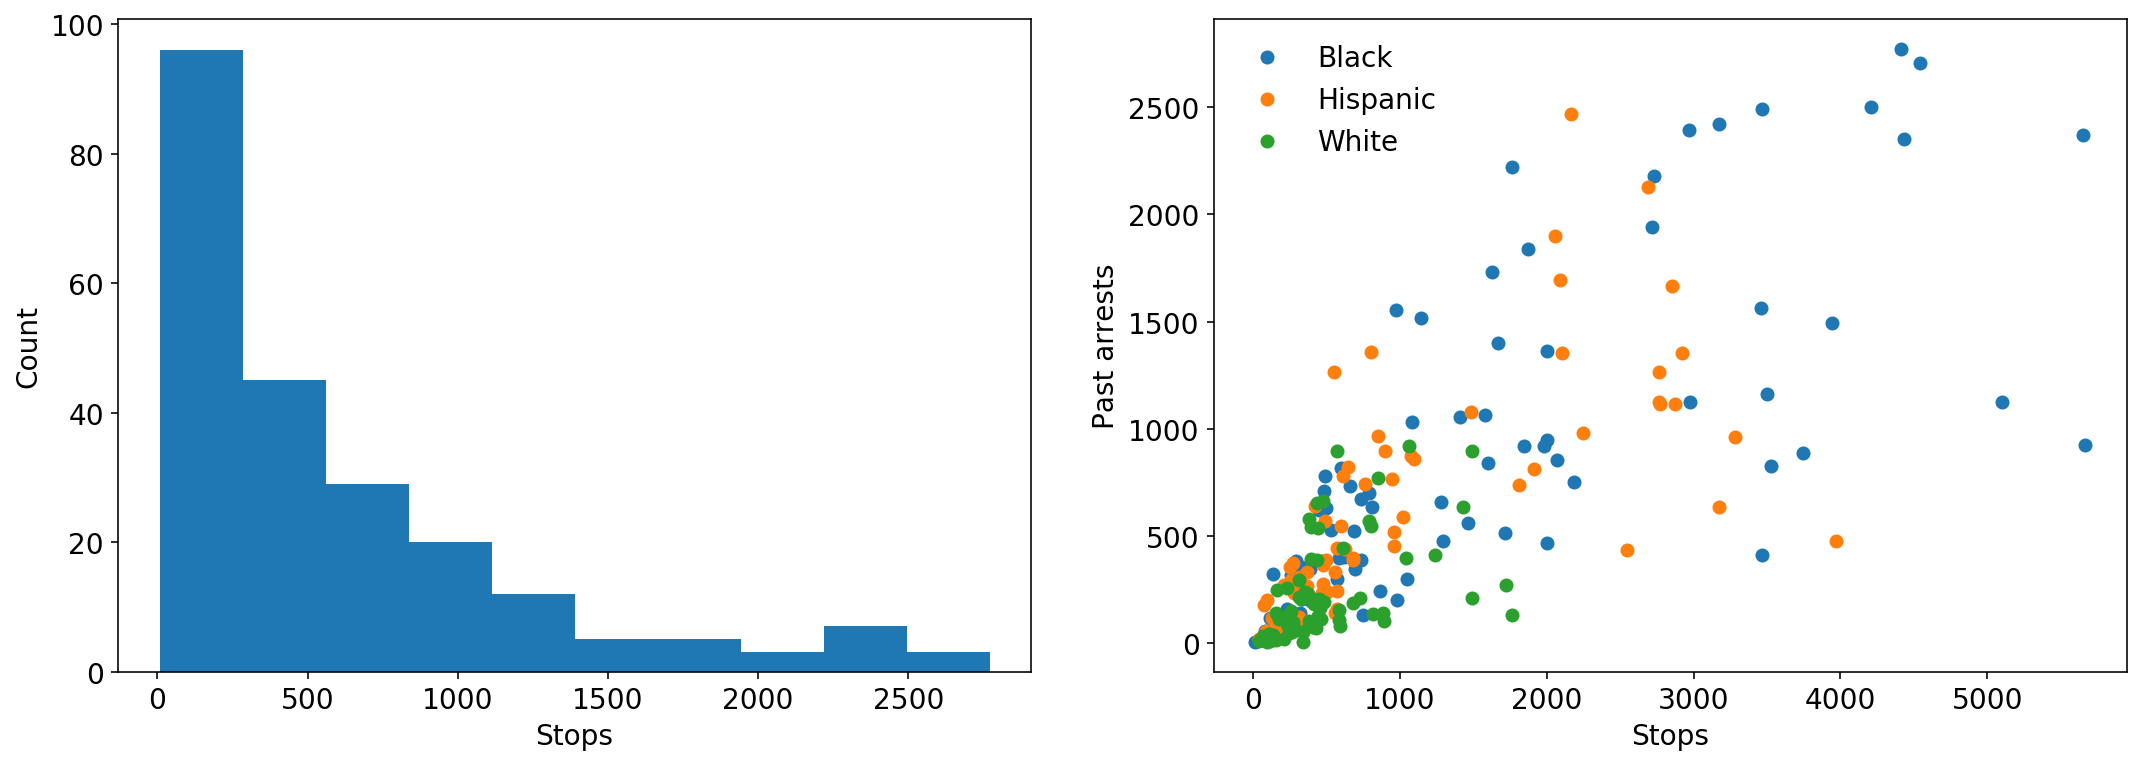

In [134]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].hist(df2.stops)
axes[0].set_xlabel("Stops")
axes[0].set_ylabel("Count")
axes[1].plot(df2.loc[df2.eth_1 == 1].past_arrests, df2.loc[df2.eth_1 == 1].stops, 'o', label="Black")
axes[1].plot(df2.loc[df2.eth_2 == 1].past_arrests, df2.loc[df2.eth_2 == 1].stops, 'o', label="Hispanic")
axes[1].plot(df2.loc[df2.eth_3 == 1].past_arrests, df2.loc[df2.eth_3 == 1].stops, 'o', label="White")
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].set_ylabel("Past arrests", fontsize=14)
# plt.rc('font', size=14)
plt.legend(frameon=False)
plt.show()

## Poisson regression, exposure and overdispersion

In [105]:
model_no_indicators = sm.GLM(
    df2.stops,
    df2[["intercept"]],
    offset=np.log(df2.past_arrests),
    family=sm.families.Poisson(),
)

In [106]:
result_no_indicators = model_no_indicators.fit()
result_no_indicators.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      224
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23913.
Date:                Wed, 13 May 2020   Deviance:                       46120.
Time:                        06:02:50   Pearson chi2:                 4.96e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5877      0.003   -213.058      0.000      -0.593      -0.582
==============================================================================
"""

In [108]:
model_with_ethnicity = sm.GLM(
    df2.stops,
    df2[['intercept', 'eth_2', 'eth_3']],
    offset=np.log(df2.past_arrests),
    family=sm.families.Poisson(),
)

In [110]:
result_with_ethnicity = model_with_ethnicity.fit()
result_with_ethnicity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  stops   No. Observations:                  225
Model:                            GLM   Df Residuals:                      222
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23572.
Date:                Wed, 13 May 2020   Deviance:                       45437.
Time:                        06:03:53   Pearson chi2:                 4.94e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5881      0.004   -155.396      0.000      -0.596      -0.581
eth_2          0.0702      0.006     11.584      0.000       0.058       0.082
eth_3         -0.1616      0.009    -18.881      0.000      -0.178      -0.145
==============================================================================
"""

In [136]:
model_with_ethnicity_and_precinct = sm.GLM(
    df2.stops,
    df2.drop(columns=["stops", "eth_1", "precinct_1"]),
    offset=np.log(df2.past_arrests),
    family=sm.families.Poisson(),
)

In [1]:
result_with_ethnicity_and_precinct = model_with_ethnicity_and_precinct.fit()

### Overdispersion

In [145]:
def group_residuals(y_true, y_pred, n_groups=20, offset=0):
    residuals = y_true - y_pred
    quantiles = pd.qcut(y_true, n_groups, labels=False)
    groups = residuals.groupby(quantiles)
    mean = groups.mean()
    std = groups.std()
    return mean.index + offset, mean.values, std.values

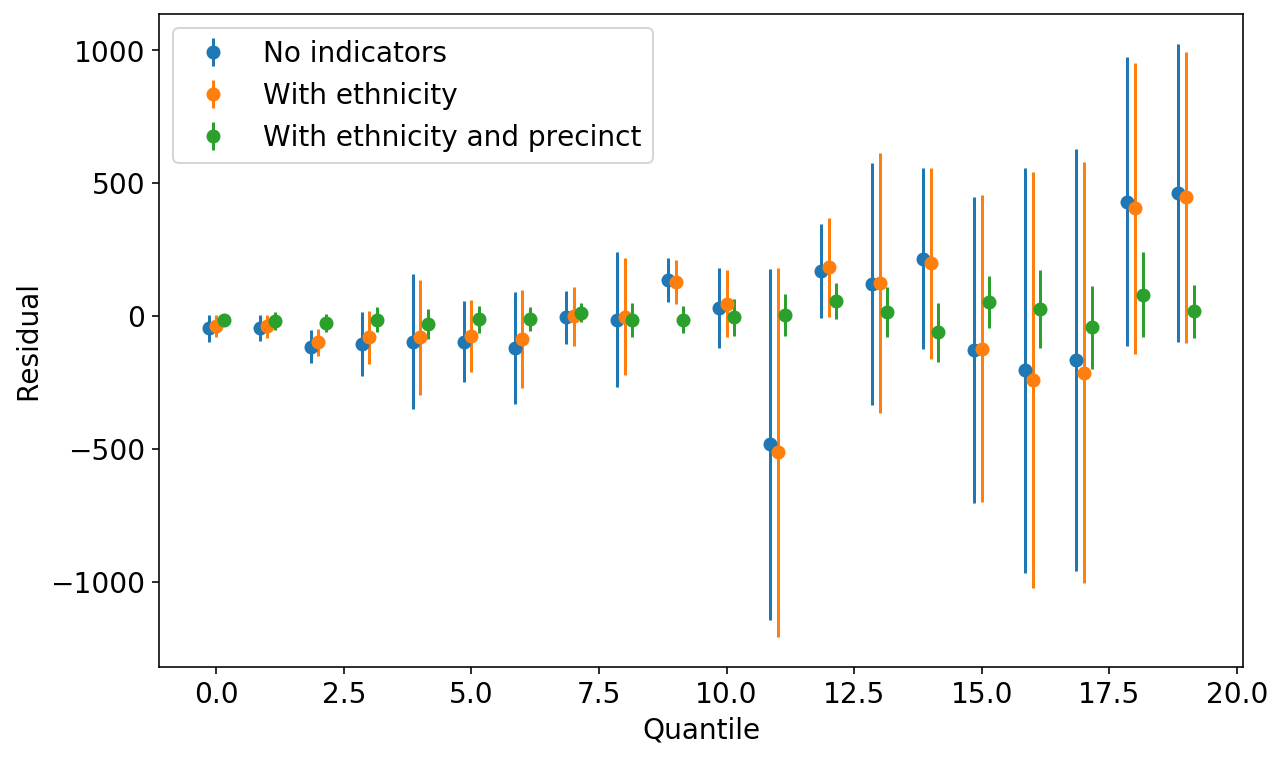

In [146]:
f = plt.figure(figsize=(6 * 1.618, 6))
plt.errorbar(
    *group_residuals(df2.stops, result_no_indicators.fittedvalues, offset=-0.15),
    label='No indicators',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity.fittedvalues),
    label='With ethnicity',
    marker='o',
    linestyle=''
)
plt.errorbar(
    *group_residuals(df2.stops, result_with_ethnicity_and_precinct.fittedvalues, offset=0.15),
    label='With ethnicity and precinct',
    marker='o',
    linestyle=''
)

plt.xlabel("Quantile", fontsize=14)
plt.ylabel("Residual", fontsize=14)
plt.legend(loc='upper left')
plt.show()

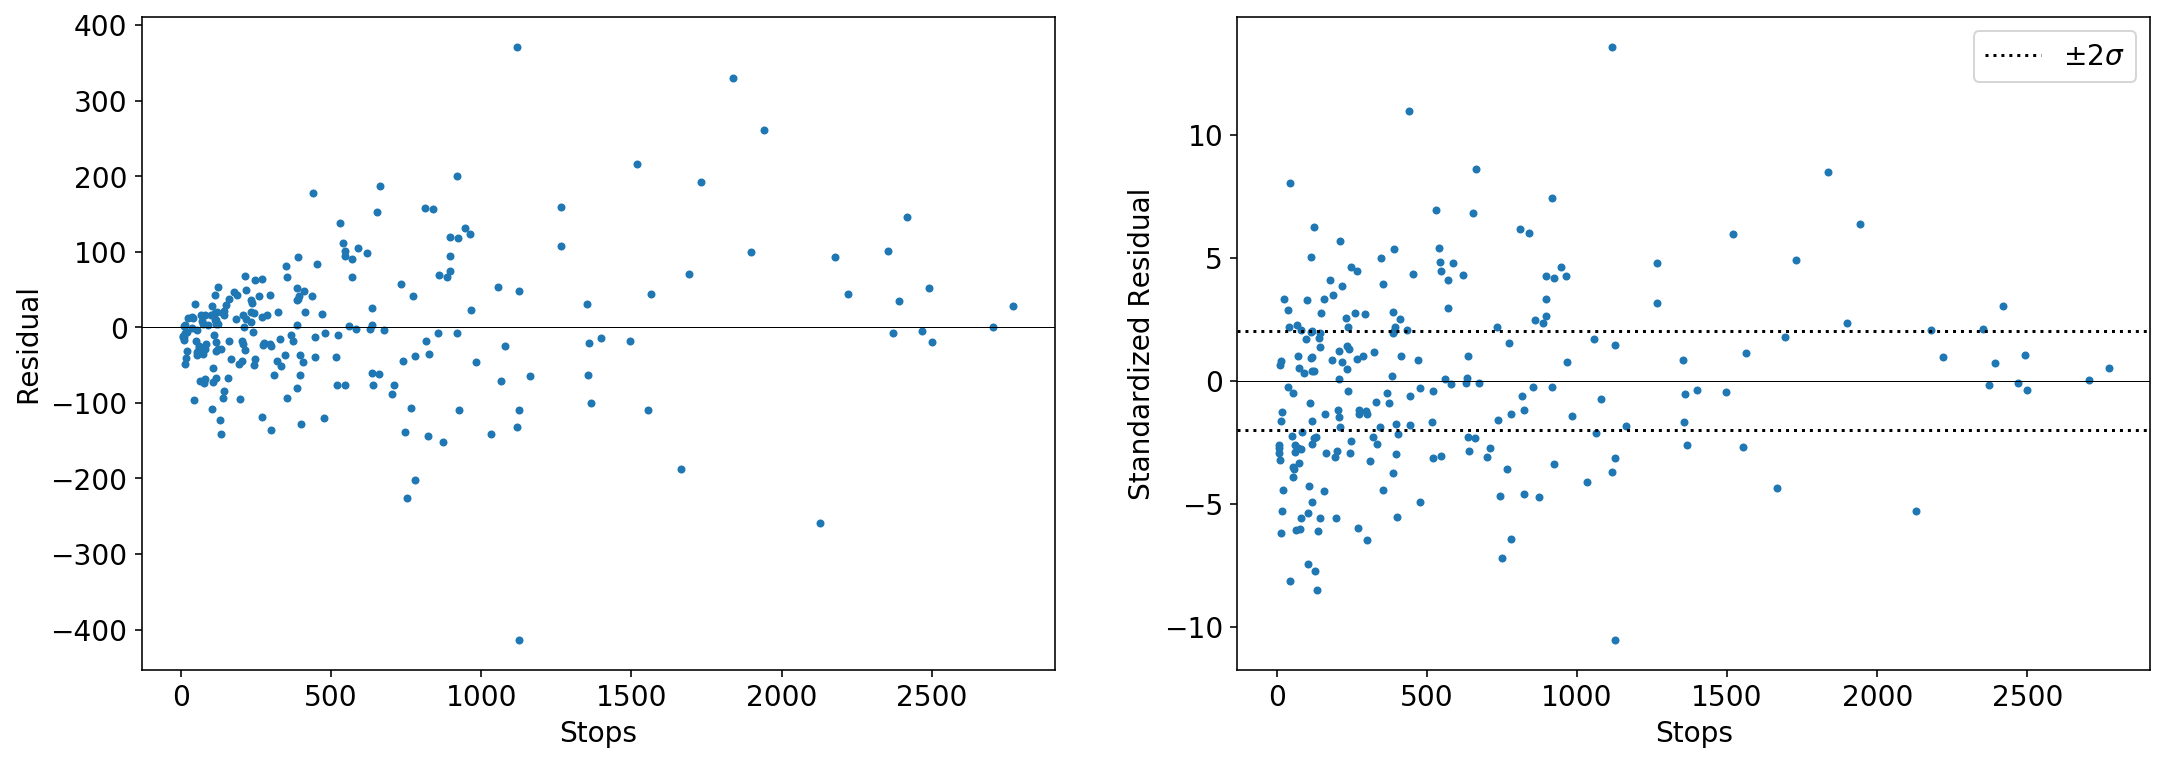

In [161]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(
    df2.stops,
    df2.stops - result_with_ethnicity_and_precinct.fittedvalues,
    marker='.',
    linestyle=''
)
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel("Residual", fontsize=14)
axes[0].set_xlabel("Stops", fontsize=14)

axes[1].plot(
    df2.stops,
    (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues),
    marker='.',
    linestyle=''
)

axes[1].axhline(y=-2, linestyle=':', color='black', label="$\pm 2\sigma$")
axes[1].axhline(y=+2, linestyle=':', color='black',)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel("Standardized Residual", fontsize=14)
axes[1].set_xlabel("Stops", fontsize=14)
axes[1].legend()


plt.show()

The standardised residuals are already stored in the fitted model in the attribute `resid_pearson`, so we don't need to compute these by hand.

In [233]:
z_residuals = (df2.stops - result_with_ethnicity_and_precinct.fittedvalues) / np.sqrt(result_with_ethnicity_and_precinct.fittedvalues)
(z_residuals == result_with_ethnicity_and_precinct.resid_pearson).all()

True

In [231]:
overdispersion_ratio = sum(result_with_ethnicity_and_precinct.resid_pearson ** 2) / result_with_ethnicity_and_precinct.df_resid
overdispersion_test = scipy.stats.chisquare(
    result_with_ethnicity_and_precinct.resid_pearson,
    ddof=result_with_ethnicity_and_precinct.df_resid,
)

In [232]:
print(f"Overdispersion ratio is {overdispersion_ratio:.2f}")
print(f"p-value of overdispersion test is {overdispersion_test.pvalue:.2f}")

Overdispersion ratio is 21.24
p-value of overdispersion test is 1.00
